# Analysis of molecular excitations
This notebook deas with the main quantities associated to Linear Response Casida formalism.
After the calculation of the couling matrices have been performed by a BigDFT run, with this notebook we calculate the molecule' s excitation
and we plot relevant quantities associated with them.


## Load the relevant modules
See their documentation here https://bigdft-suite.readthedocs.io/projects/PyBigDFT/en/latest/index.html 

In [3]:
import sys,os.path as path
sys.path.insert(0,path.join('/bigdft-sdk','build-cuda9-ompi-1.8.3','install','lib','python2.7','site-packages'))
from BigDFT import Logfiles as lf
from futile.Utils import write
import numpy as np
import matplotlib
import LRTDDFT as LR

## Create functions to explore the directory and create the database
These function explore the directory of the various molecular runs. Typically in such directory it is expected to find one or more run of a singe molecule,
perhaps with different sizes of the simulation domains. Once the `molecule_data` database is created the `Excitations` class is instanciated and analysed according to a given threshold

In [4]:
def read_data_directory(molecule_dir):
    """
    Retrieve all the logfiles in molecule_dir and extract the corresponding Transition Matrices
    """
    import os
    molecule_data={}
    for f in os.listdir(molecule_dir):
        if f.startswith('log-'):
            data=lf.Logfile(os.path.join(molecule_dir,f))
            rmult=data.log['dft']['rmult'][0]
            cm=LR.CouplingMatrix(log=data)
            try:
                tm=LR.TransitionMultipoles(log=data)
            except:
                write('The transition multipoles were not loaded, try with old code format')
                tm=LR.TransitionDipoles(log=data)
            molecule_data[rmult]={'log':data,'coupling_matrix':cm,'transition_multipoles': tm}
    return molecule_data

def sorted_keys(molecule_data):
    sorted_keys=molecule_data.keys()
    sorted_keys.sort()
    return sorted_keys

def calculate_excitations(molecule_data):
    """
    From the transition quantities calculate the Excitation class
    """
    for run in sorted_keys(molecule_data):
        cm=molecule_data[run]['coupling_matrix']
        tm=molecule_data[run]['transition_multipoles']
        molecule_data[run]['excitations']=LR.Excitations(cm,tm)

def split_excitations(molecule_data,tol=1.e-2,nexc='all'):
    """
    Split the Excitation classes according to a given tolerance
    """
    for run in sorted_keys(molecule_data):
        log=molecule_data[run]['log']
        ex=molecule_data[run]['excitations']
        sizes = np.array(log.log['Sizes of the simulation domain']['Angstroem'])
        size=np.max(sizes)
        molecule_data[run]['size']=size
        write('Splitting excitations for run of size',size,', tolerance=',tol)
        ex.split_excitations(evals=log.evals[0],tol=tol,nexc=nexc)
        write('Found ',len(ex.excitations_below_threshold[0]),'/',len(ex.eigenvalues) if nexc == 'all' else nexc,' excitations below threshold')


## Plotting functions
The functions below are provided to ease the plotting of the molecule database. They provides facilities for the most common operations, like plotting of dynamical polarizability, excitation Density of States and Lanscape. Also the $S_{-2}$ sum rule can be plotted and compared to a reference value that might be provided.

In [5]:
def plot_spectra(label,molecule_data,group='all'):
    colors=['red','blue','black']
    for real in [False,True]:
        for i,run in enumerate(sorted_keys(molecule_data)):
            log=molecule_data[run]['log']
            ex=molecule_data[run]['excitations']
            size=molecule_data[run]['size']
            lab=str(size) + ' $\AA$'
            pl=ex.plot_alpha(real=real,group=group,c=colors[i],label=lab)
        pl.title(label)
        pl.legend(loc='best')
        pl.show()
        
def plot_excitation_landscapes(label,molecule_data,xlim):
    for run in sorted_keys(molecule_data):
        ex=molecule_data[run]['excitations']
        size=molecule_data[run]['size']
        pl=ex.plot_excitation_landscape(title=label+' Excitations Landscape, size '+ str(size) + '$\AA$',xlim=xlim)
        pl.show()

def plot_excitation_dos(label,molecule_data):
    for group in ['all','bt','at']:
        for i,run in enumerate(sorted_keys(molecule_data)):
            ex=molecule_data[run]['excitations']
            size=molecule_data[run]['size']
            lab=str(size) + ' $\AA$'
            if i==0: 
                dos=ex.dos(group=group,label=lab)
            else:
                kwargs=ex.dos_dict(group=group)
                kwargs['label']=lab
                dos.append(**kwargs)
        dos.plot(sigma=0.002 if group == 'bt' else 0.2)

def plot_Sm2(label,molecule_data,coord,alpha_ref=None):
    for i,run in enumerate(sorted_keys(molecule_data)):
        ex=molecule_data[run]['excitations']
        size=molecule_data[run]['size']
        pl=ex.plot_Sminustwo(coord,alpha_ref=alpha_ref)
        pl.title(label+' $S_{-2}$ along '+coord+', size '+ str(size) + '$\AA$')
        pl.xlim([0,40])
        pl.show()

## Analysis of the database
The function below is a commodity function that performs the plot of a molecular database. It might be called at a glance to inspect the molecule's behaviour.

In [6]:
%matplotlib inline
def analyze_molecule_data(label,molecule_data,alpha_ref=None):
    """
    Plot the relevant quantities of the molecule. Such function performs:
       * The plot of the real and imaginary part of the absorbption spectra
       * The excitations landscapes of each of the molecule data
       * The excitation DoS separated in the belot_threshold and above_threshold groups
       * The S_{-2} sum rule compared with the reference values of the polarizability tensor, if given
    """
    write(16*'-','Dynamical polarizability, imaginary and real part')
    plot_spectra(label,molecule_data)
    write(16*'-','Excitation landscapes')
    plot_excitation_landscapes(label,molecule_data,[0,20])
    write(16*'-','Dynamical polarizability, localized excitations only')
    plot_spectra(label,molecule_data,'bt')
    write(16*'-','Excitations density of states, complete and splitted')
    plot_excitation_dos(label,molecule_data)
    write(16*'-','Static polarizability sum rule, "x" coordinate')
    plot_Sm2(label,molecule_data,'x',alpha_ref=alpha_ref)
    write(16*'-','Static polarizability sum rule, "y" coordinate')
    plot_Sm2(label,molecule_data,'y',alpha_ref=alpha_ref)
    write(16*'-','Static polarizability sum rule, "z" coordinate')
    plot_Sm2(label,molecule_data,'z',alpha_ref=alpha_ref)

# The $CO$ molecule
Let us read the database associated to the Carbon Monoxide molecule. We have calculate via finite-differences the reference values for the diagonal part of the polarizability tensor.

In [7]:
CO_alpha_ref = [13.235, 13.235, 18.728] #we use a stretched molecule of R=1.235 A

In [8]:
CO_data=read_data_directory('CO/linear-response/log')

Loading data with  (5,)  occupied and  (280,)  empty states, from file " /home/marco/Data/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_10.0/coupling_matrix.txt "
Using numpy:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /home/marco/Data/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_10.0/transition_quantities.txt "
Using numpy:
done
Shape is conformal with the number of orbitals
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /home/marco/Data/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log/data-Rmult_9.0/coupling_matrix.txt "
Using numpy:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /home/marco/Data/RICERCA/LINEAR RESPONSE/LR-nb/P

In [9]:
calculate_excitations(CO_data)

Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved


In [10]:
split_excitations(molecule_data=CO_data)

Splitting excitations for run of size 11.552 , tolerance= 0.01
Found  11 / 2800  excitations below threshold
Splitting excitations for run of size 15.076 , tolerance= 0.01
Found  12 / 2800  excitations below threshold
Splitting excitations for run of size 16.643 , tolerance= 0.01
Found  12 / 2800  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


/opt/intel/intelpython2/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


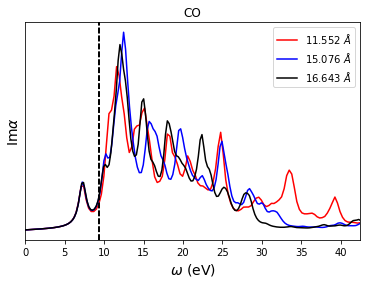

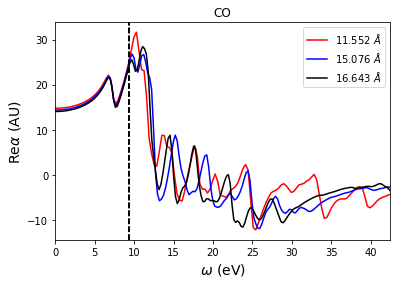

---------------- Excitation landscapes


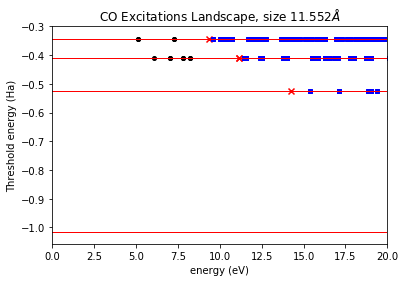

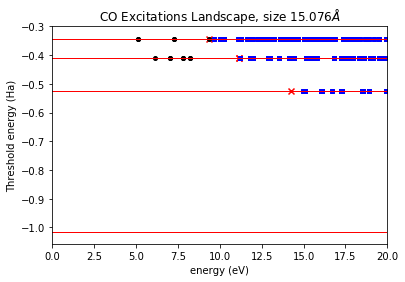

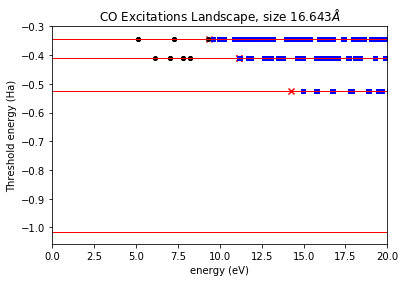

---------------- Dynamical polarizability, localized excitations only


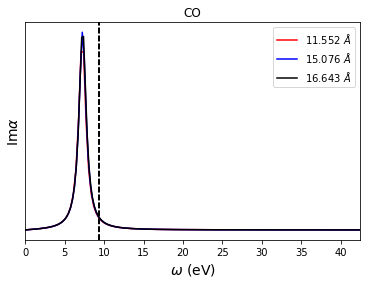

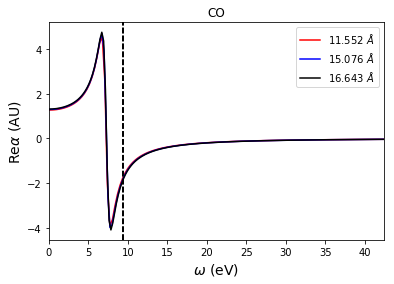

---------------- Excitations density of states, complete and splitted


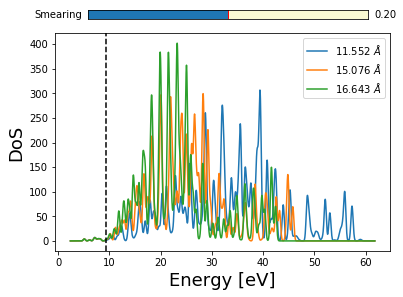

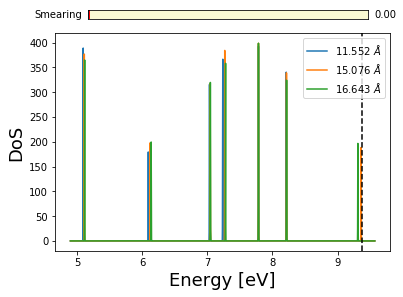

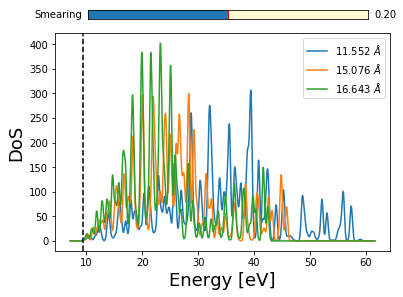

---------------- Static polarizability sum rule, "x" coordinate


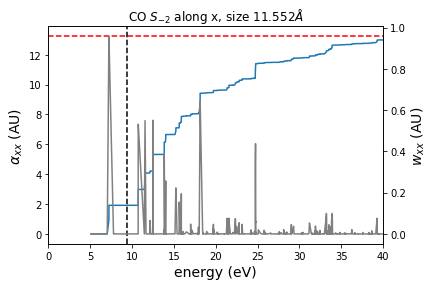

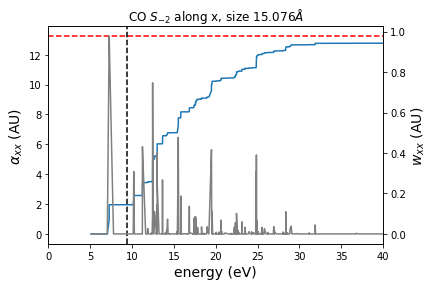

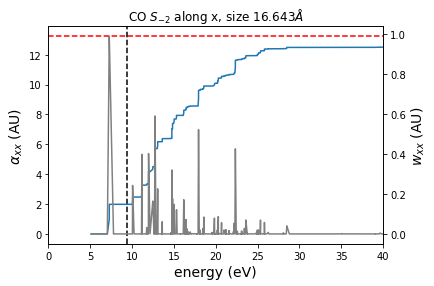

---------------- Static polarizability sum rule, "y" coordinate


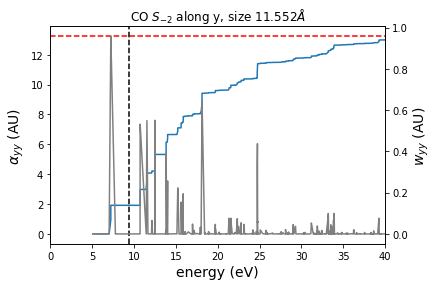

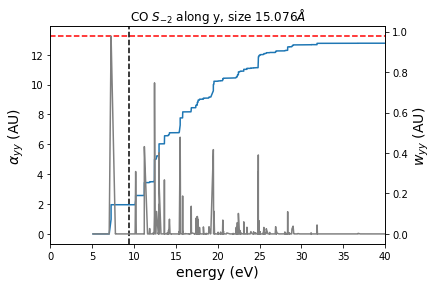

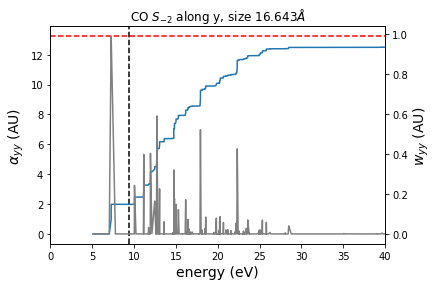

---------------- Static polarizability sum rule, "z" coordinate


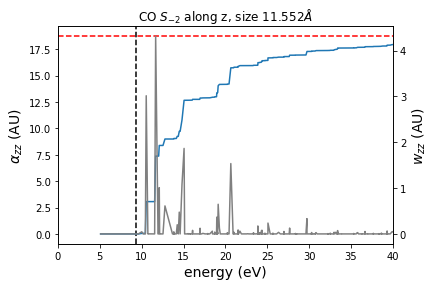

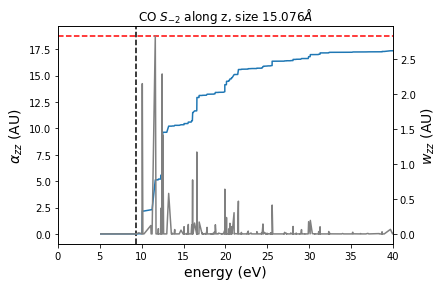

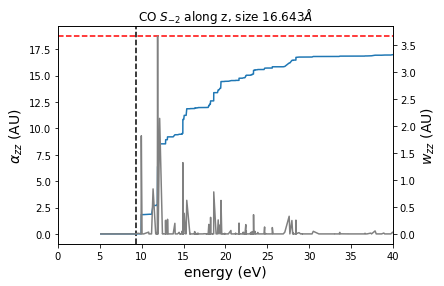

In [11]:
analyze_molecule_data('CO',CO_data,alpha_ref=CO_alpha_ref)

Write the real part of the polarizability on file (to be included in the proper function...)

In [61]:
HaeV=27.21138386
eta = 1.e-2
import matplotlib.pyplot as plt

In [62]:
alphaReal = {}
omega = {}
for run in CO_data.keys():
    exc = CO_data[run]['excitations']
    emax=np.max(np.sqrt(exc.eigenvalues))
    o=np.linspace(0.0,emax,500)+2.0*eta*1j
    omega[run]=o.real*HaeV
    alphaReal[run]=exc.spectrum_curves(o).real

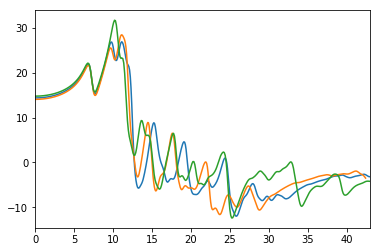

In [63]:
for run in CO_data.keys():
    plt.plot(omega[run],alphaReal[run])
plt.xlim(0,43)
plt.show()

In [64]:
for run in CO_data.keys():
    fname = 'CO_alphaOmegaRealPart_rmult'+str(run)+'.txt'
    print fname
    f = open(fname,'w')
    for o,a in zip(omega[run],alphaReal[run]):
        s = str(o)+'\t'+str(a)+'\n'
        f.write(s)
    f.close()

CO_alphaOmegaRealPart_rmult9.0.txt
CO_alphaOmegaRealPart_rmult10.0.txt
CO_alphaOmegaRealPart_rmult7.0.txt


## Considerations
The CO molecule has only localized states below the first ionization threshold. For this reason its excitation spectrum is deeply influenced by the excitation density of states in the continuum sector. This is particularly visible in the sum-rule for the static polarizability, where it can be seen that only the states
above threshold contributes. However, there is a bright peak in the below-threshod regime that easily converges with respect to the size of the simulation domain.

# The Benzene molecule
We now perform the same analysis with a slightly larger molecule, Benzene.
We also here provide the reference static polarizability values for comparison.

In [12]:
C6H6_alpha_ref = [83.86,83.86,45.62]

In [13]:
C6H6_data=read_data_directory('C6H6/linear-response/log')

Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_9.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_9.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (15,)  occupied and  (220,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of o

In [14]:
calculate_excitations(C6H6_data)

Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved
Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved
Diagonalizing Coupling matrix of shape (6600, 6600)
Eigensystem solved


In [15]:
split_excitations(molecule_data=C6H6_data,tol=5.e-2)

Splitting excitations for run of size 15.664 , tolerance= 0.05
Found  41 / 6600  excitations below threshold
Splitting excitations for run of size 18.839 , tolerance= 0.05
Found  47 / 6600  excitations below threshold
Splitting excitations for run of size 20.32 , tolerance= 0.05
Found  55 / 6600  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


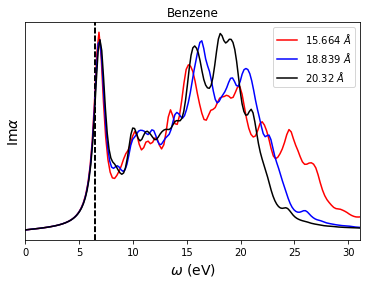

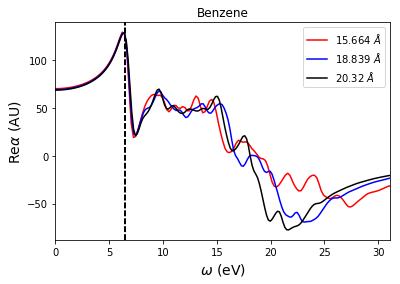

---------------- Excitation landscapes


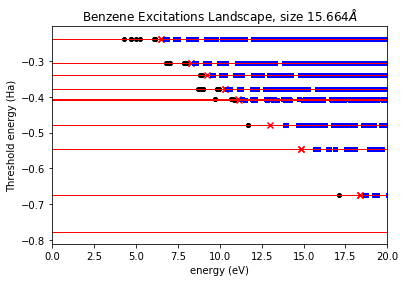

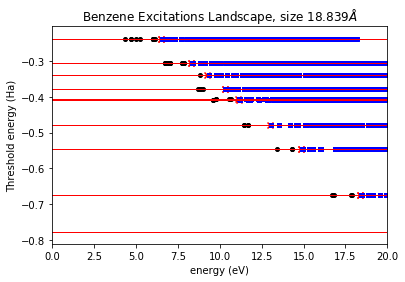

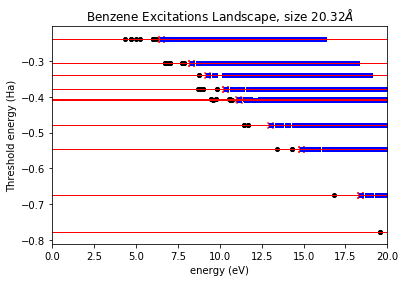

---------------- Dynamical polarizability, localized excitations only


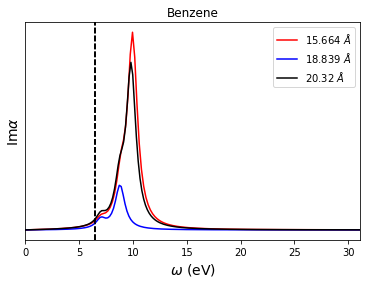

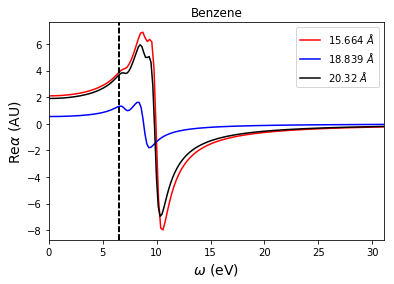

---------------- Excitations density of states, complete and splitted


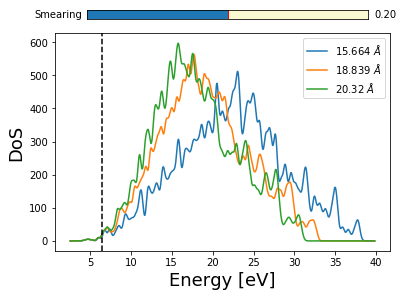

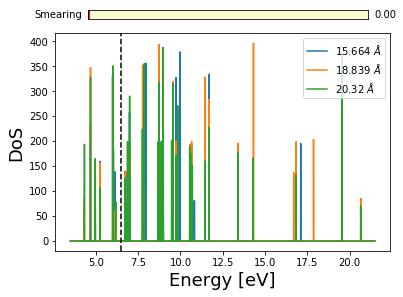

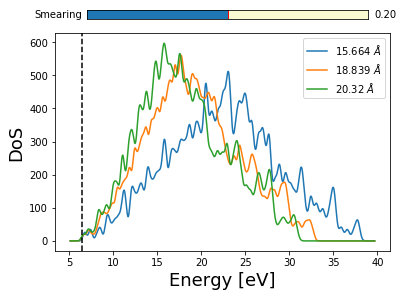

---------------- Static polarizability sum rule, "x" coordinate


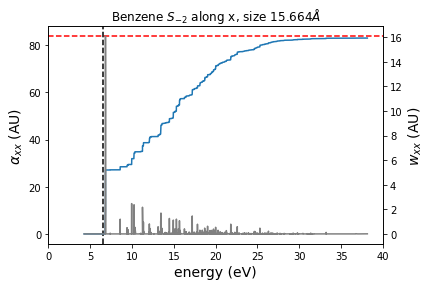

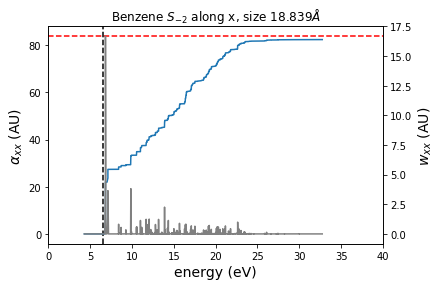

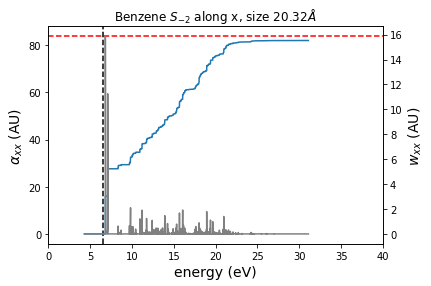

---------------- Static polarizability sum rule, "y" coordinate


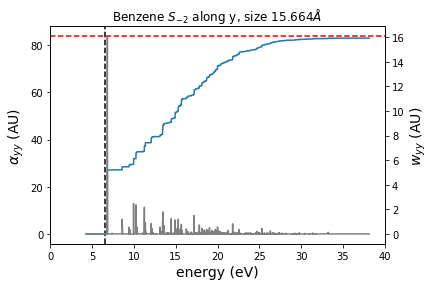

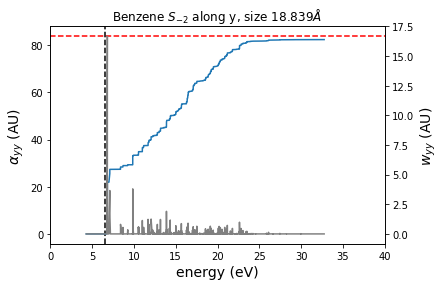

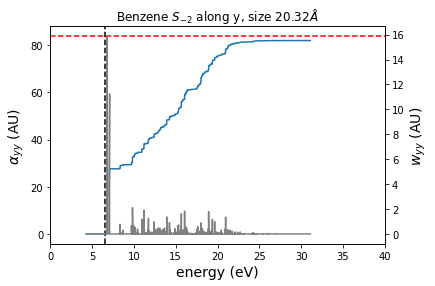

---------------- Static polarizability sum rule, "z" coordinate


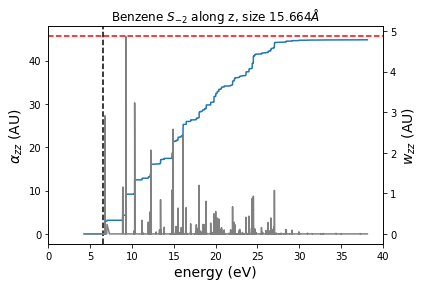

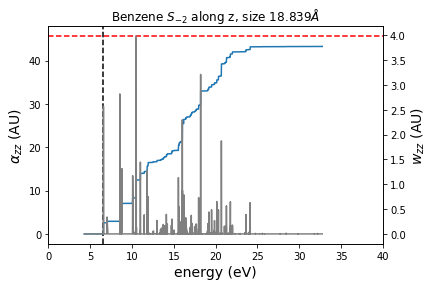

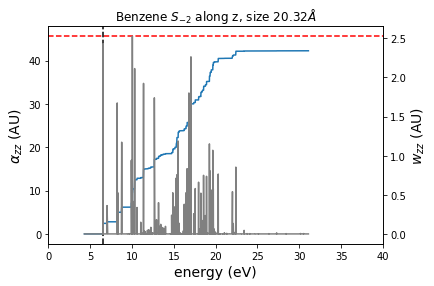

In [16]:
analyze_molecule_data('Benzene',C6H6_data,alpha_ref=C6H6_alpha_ref)

## Considerations
The Benzene molecule has also some localized excitations above the first ionization threshold, though their identification might be noisy.
In particular, the box of intermediate size might exhibit some extra degeneracies of the localized excitations with some delocalized states in the continuum, which hinders their identification with the naive method implemented here.
Nonetheless, it appears clearly that these localized portion of the spectra, are *not* sufficient to express the linear-response properties of the molecule.
This is visible either from the absorption spectra, which are drastically different by only considering below-threshold excitations, and also from the static polarizability sum rule, which incidentally is very-well satisfied also for the small box. As a further confirmation we plot here the $S_{-2}$ plot for the localized states only of the small box size:


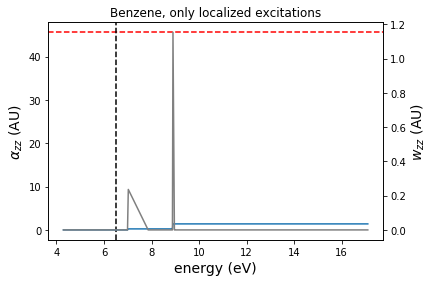

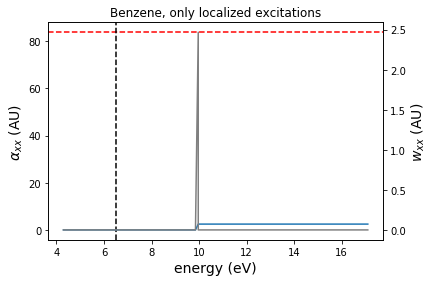

In [17]:
ex=C6H6_data[7.0]['excitations']
pt=ex.plot_Sminustwo(coord='z',group='bt',alpha_ref=C6H6_alpha_ref)
pt.title('Benzene, only localized excitations')
pt.show()
pt=ex.plot_Sminustwo(coord='x',group='bt',alpha_ref=C6H6_alpha_ref)
pt.title('Benzene, only localized excitations')
pt.show()

We can easily see that the localized sector is *strongly* insufficient to encode LR information on $\alpha(\omega=0)$, even if the corresponding fluctuation state is localized.

# Water molecule
We may also retrieve the same quantities for the $H_2O$ molecule. We provide approximate values for the $alpha_{yy}$ component in this preliminary example.

In [18]:
H2O_alpha_ref=[10.92749556,10.92749556,10.743]

In [19]:
H2O_data=read_data_directory('H2O/linear-response/log')

Loading data with  (4,)  occupied and  (297,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/H2O/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (4,)  occupied and  (297,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/H2O/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (4,)  occupied and  (283,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/H2O/linear-response/log/data-Rmult_9.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (4,)  occupied and  (283,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/H2O/linear-response/log/data-Rmult_9.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


In [20]:
calculate_excitations(H2O_data)

Diagonalizing Coupling matrix of shape (2376, 2376)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2264, 2264)
Eigensystem solved


In [21]:
split_excitations(H2O_data)

Splitting excitations for run of size 12.335 , tolerance= 0.01
Found  2 / 2376  excitations below threshold
Splitting excitations for run of size 15.468 , tolerance= 0.01
Found  2 / 2264  excitations below threshold


**WARNING**: due to a (corrected!) error in the initial calculation the oscillator strenghts are multiplied by the square number of MPI processes.
We therefore compare the references wrt the multiplied values. **There is a multiplicative factor on the oscillator strenghts**

---------------- Dynamical polarizability, imaginary and real part


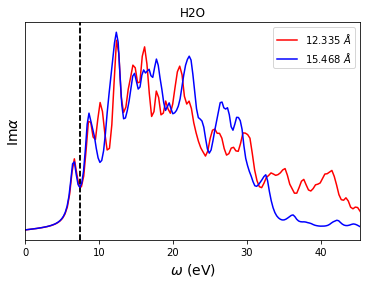

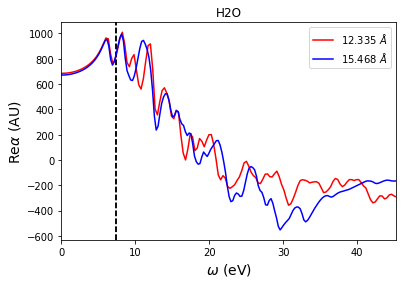

---------------- Excitation landscapes


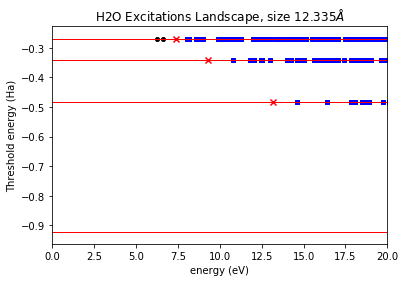

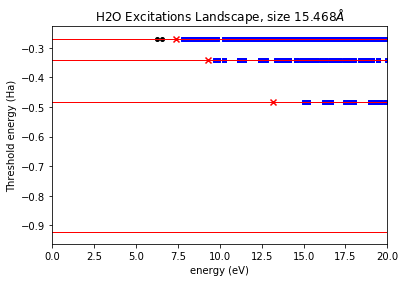

---------------- Dynamical polarizability, localized excitations only


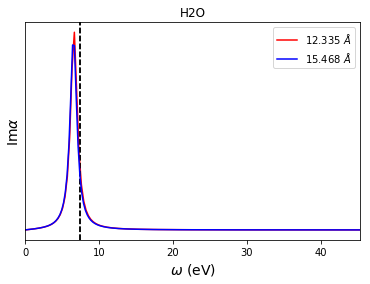

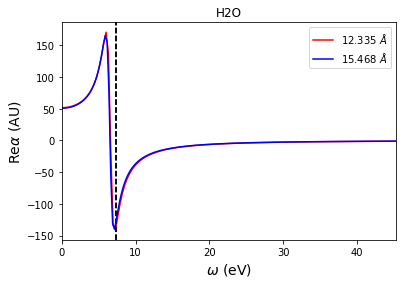

---------------- Excitations density of states, complete and splitted


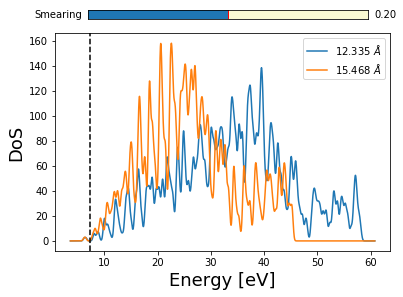

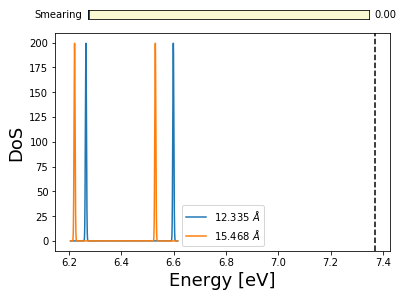

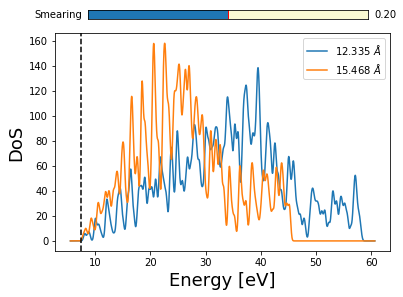

---------------- Static polarizability sum rule, "x" coordinate


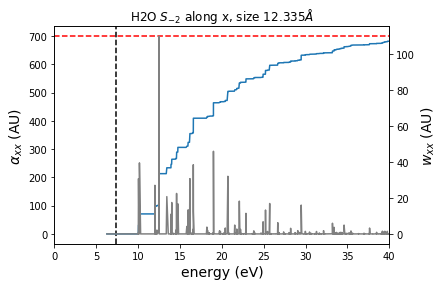

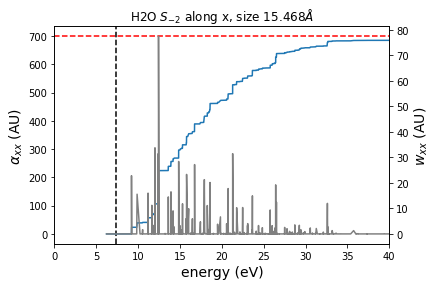

---------------- Static polarizability sum rule, "y" coordinate


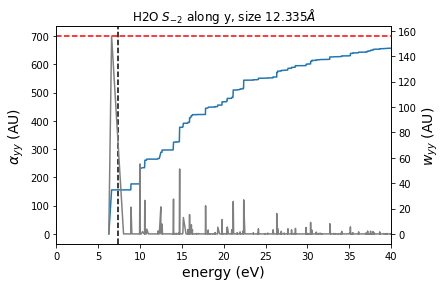

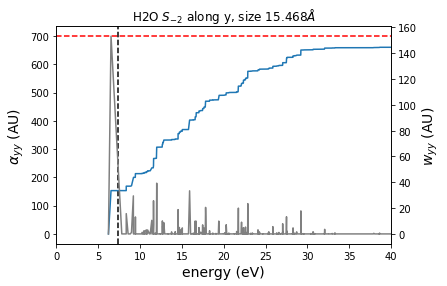

---------------- Static polarizability sum rule, "z" coordinate


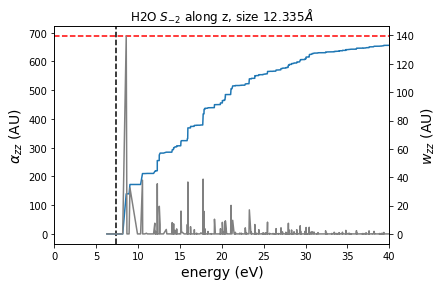

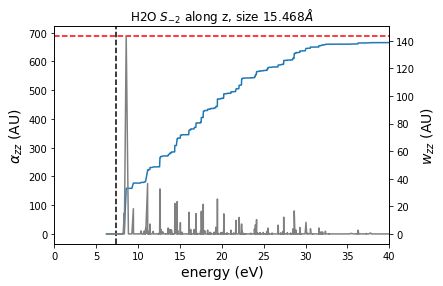

In [22]:
analyze_molecule_data('H2O',H2O_data,alpha_ref=64*np.array(H2O_alpha_ref))

## Considerations.
The Water molecule behaves very much like the CO case, with a bright peak below threshold. However it might be seen that the localized excitations are not yet at convergence with the largest box size, as their energy value are moved wrt the small box. However, the panorama is largely dominated by the continuum sector of the excitations.

# The Nitrogen molecule
We also look here at a molecule which has _no bright_ peaks below threshold, like the $N_2$.

In [23]:
N2_alpha_ref=[10.868,10.868,15.735]

In [25]:
N2_data=read_data_directory('N2/free-bc/linear-response/log/')

Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/N2/free-bc/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/N2/free-bc/linear-response/log/data-Rmult_7.0/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/N2/free-bc/linear-response/log/data-Rmult_10.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (5,)  occupied and  (280,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/N2/free-bc/linear-response/log/data-Rmult_10.0/transition_quantities.txt "
Using pandas:
done
Shape is conforma

In [26]:
calculate_excitations(N2_data)

Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved
Diagonalizing Coupling matrix of shape (2800, 2800)
Eigensystem solved


In [27]:
split_excitations(N2_data)

Splitting excitations for run of size 11.219 , tolerance= 0.01
Found  13 / 2800  excitations below threshold
Splitting excitations for run of size 13.97 , tolerance= 0.01
Found  13 / 2800  excitations below threshold
Splitting excitations for run of size 15.452 , tolerance= 0.01
Found  13 / 2800  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


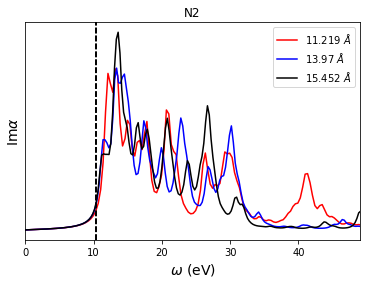

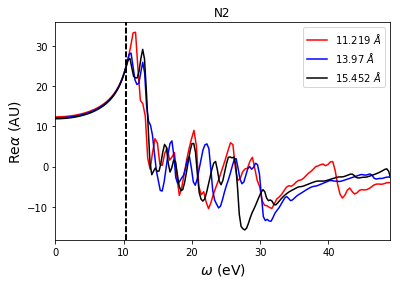

---------------- Excitation landscapes


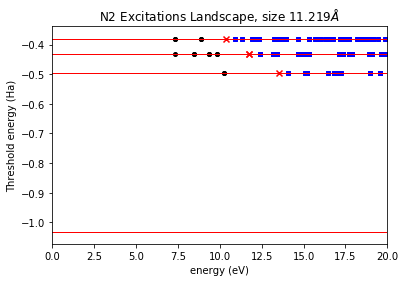

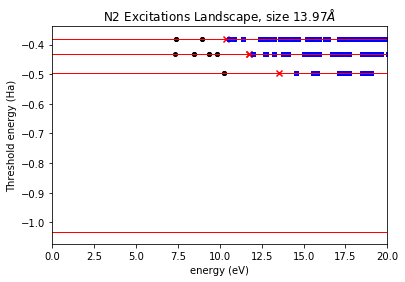

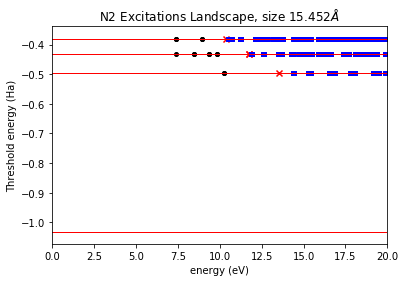

---------------- Dynamical polarizability, localized excitations only


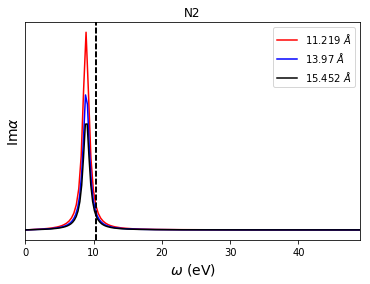

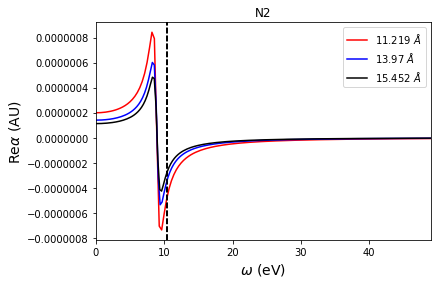

---------------- Excitations density of states, complete and splitted


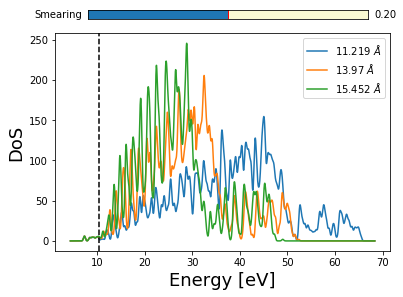

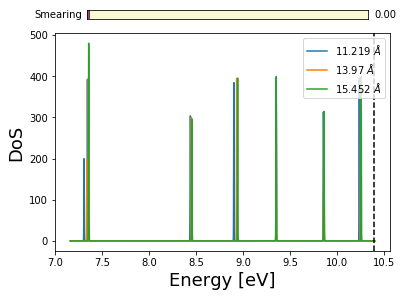

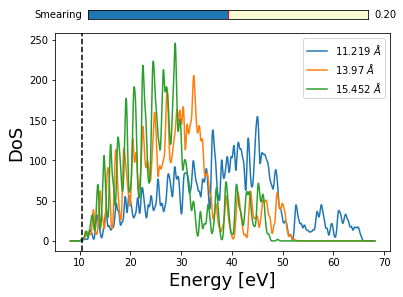

---------------- Static polarizability sum rule, "x" coordinate


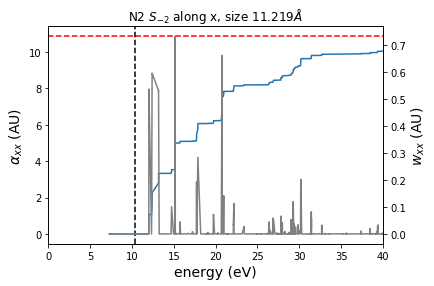

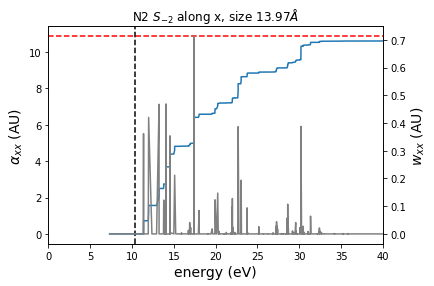

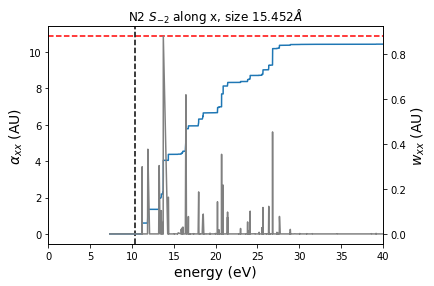

---------------- Static polarizability sum rule, "y" coordinate


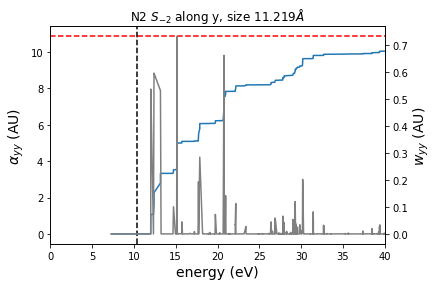

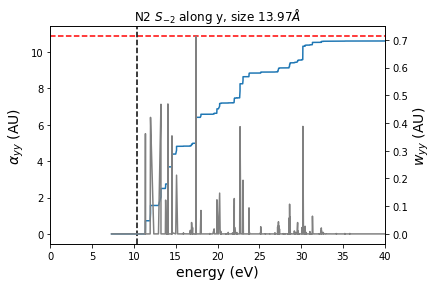

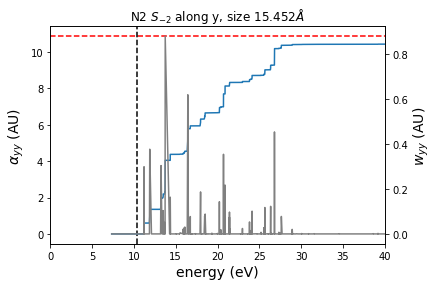

---------------- Static polarizability sum rule, "z" coordinate


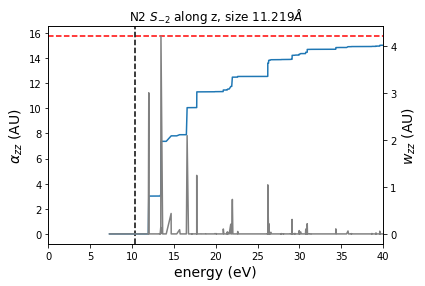

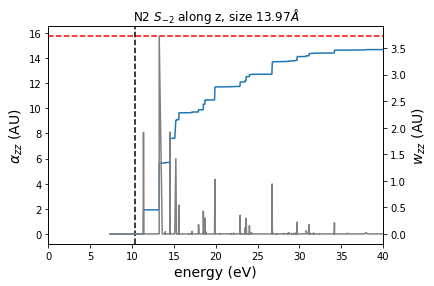

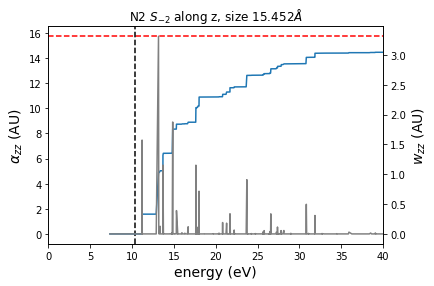

In [28]:
analyze_molecule_data('N2',N2_data,alpha_ref=N2_alpha_ref)

## Considerations, and further analysis
The absence of bright peaks below threshold complicates the task of finding a converged absorbption spectrum for the $N_2$ molecule.
However, there is a number of localized excitations below threshold that seem to be stable and converge wrt the simulation box size.
Rather surprisigly, the **first** excitation of nitrogen exhibit a behaviour which is box-dependent. its energy is:

In [29]:
write('Energy of the first state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[0])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the second state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[1])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the third state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[2])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the fourth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[3])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the fifth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[4])*LR.HaeV for run in sorted_keys(N2_data)])
write('Energy of the sixth state',[np.sqrt(N2_data[run]['excitations'].eigenvalues[5])*LR.HaeV for run in sorted_keys(N2_data)])

Energy of the first state [7.308273144120884, 7.338207052819057, 7.355372026869141]
Energy of the second state [7.344004273115779, 7.35457543061055, 7.3583122190238575]
Energy of the third state [7.344398718994666, 7.354579978000703, 7.358315168773969]
Energy of the fourth state [8.436739626027284, 8.447456650650208, 8.451661510472402]
Energy of the fifth state [8.439698496650909, 8.450443873121342, 8.45463701216327]
Energy of the sixth state [8.900361888025149, 8.929774507146039, 8.940145592620093]


In [30]:
write('Thresholds levels (Ha), first state',[N2_data[run]['excitations'].threshold_energies[0]*LR.HaeV for run in sorted_keys(N2_data)])
write('Thresholds levels (Ha), second state',[N2_data[run]['excitations'].threshold_energies[1]*LR.HaeV for run in sorted_keys(N2_data)])
write('Thresholds levels (Ha), third state',[N2_data[run]['excitations'].threshold_energies[2]*LR.HaeV for run in sorted_keys(N2_data)])

Thresholds levels (Ha), first state [-11.741005991078694, -11.741240401468211, -11.741242138937574]
Thresholds levels (Ha), second state [-10.394640815885154, -10.394886811682248, -10.394895711413888]
Thresholds levels (Ha), third state [-10.394640815885154, -10.394886811682248, -10.394895711413888]


At the LDA level of theory, the HOMO and the HOMO-1 have different levels of degeneracy:

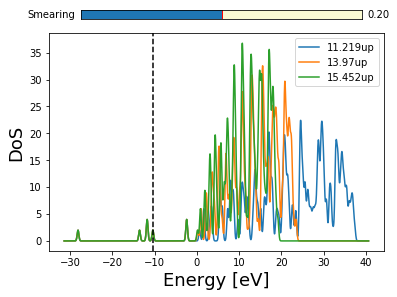

In [31]:
runs=sorted_keys(N2_data)
run=runs[0]
mol=N2_data[run]
dos=mol['log'].get_dos(label=str(mol['size']))
for run in runs[1:]:
    mol=N2_data[run]
    dos.append_from_bandarray(mol['log'].evals,label=str(mol['size']))
dos.plot()

In this figure we see both the degeneracy of the HOMO-1 and the continuum collapse of the KS states.

# Fullerene molecule
We have also available a calculation (made with a previous version of the code using different conventions for the transition quantities)
For the $C_{60}$ molecule. Let us grab this data.

In [32]:
C60_alpha_ref=[561.594233465,561.594233465,561.594233465]

In [33]:
C60_data=read_data_directory('C60/linear-response/log/')

Loading data with  (120,)  occupied and  (112,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C60/linear-response/log/data-Rmult_7.0/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
The transition multipoles were not loaded, try with old code format
Loading data with  (120,)  occupied and  (112,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/C60/linear-response/log/data-Rmult_7.0/transition_dipoles.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


As anticipated the reading of the Transition Quantities did not went through. Let us analyse the `TransitionDipoles` class instead.

In [34]:
calculate_excitations(C60_data)

Diagonalizing Coupling matrix of shape (26880, 26880)
Eigensystem solved


Let us split the excitations.

In [35]:
split_excitations(C60_data)

Splitting excitations for run of size 18.627 , tolerance= 0.01
Found  3345 / 26880  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


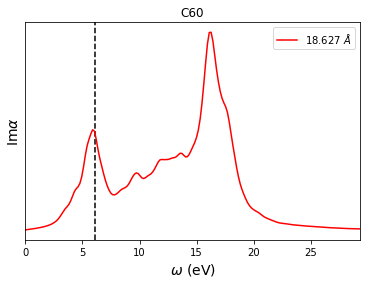

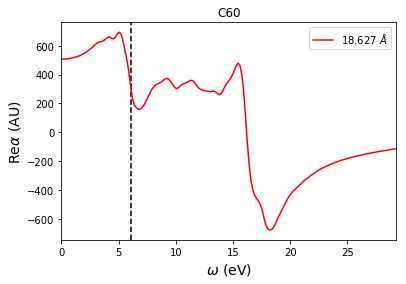

---------------- Excitation landscapes


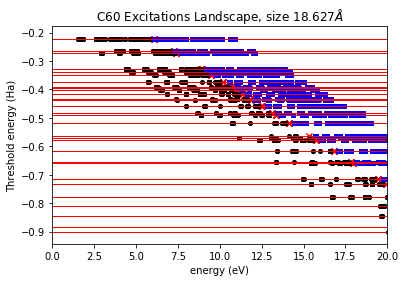

---------------- Dynamical polarizability, localized excitations only


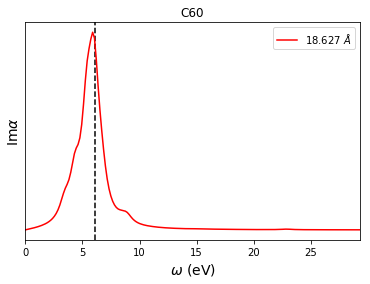

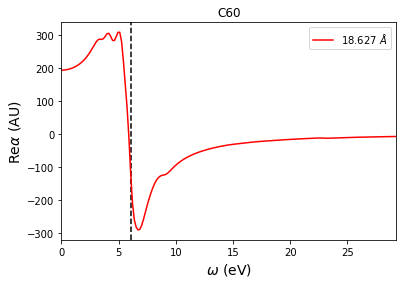

---------------- Excitations density of states, complete and splitted


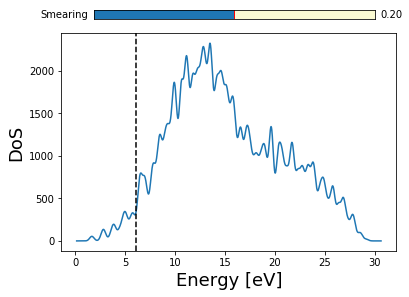

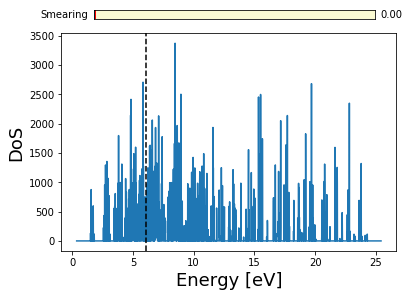

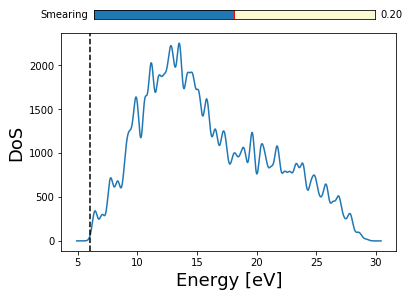

---------------- Static polarizability sum rule, "x" coordinate


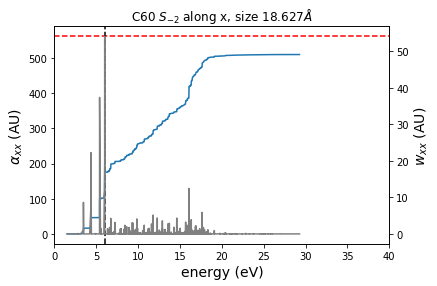

---------------- Static polarizability sum rule, "y" coordinate


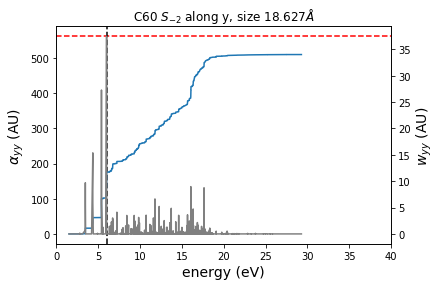

---------------- Static polarizability sum rule, "z" coordinate


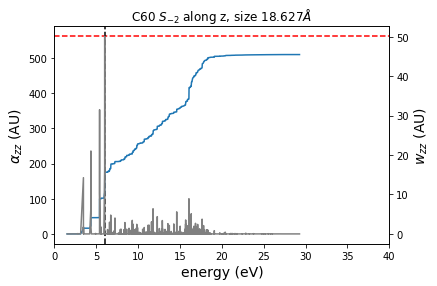

In [36]:
analyze_molecule_data('C60',C60_data,alpha_ref=C60_alpha_ref)

## Considerations
The Fullerene molecule, as it is larger, presents a large number  of localized excitation in the spectrum.
In addition this is in line with the consideration that localized states might contribute more to the static polarizability.
Let us verify this explicitly:

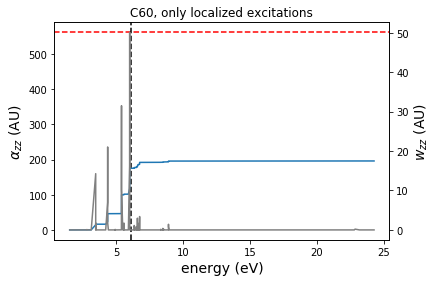

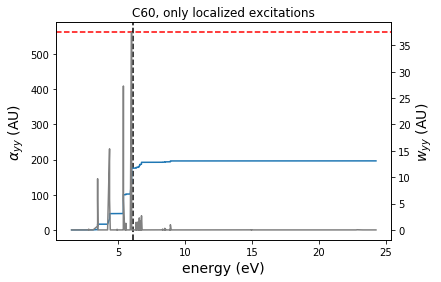

In [37]:
ex=C60_data[7.0]['excitations']
pt=ex.plot_Sminustwo(coord='z',group='bt',alpha_ref=C60_alpha_ref)
pt.title('C60, only localized excitations')
pt.show()
pt=ex.plot_Sminustwo(coord='y',group='bt',alpha_ref=C60_alpha_ref)
pt.title('C60, only localized excitations')
pt.show()

It might be also interesting to verify which portion of the absorbtion spectra are captured by the localized states in this case.

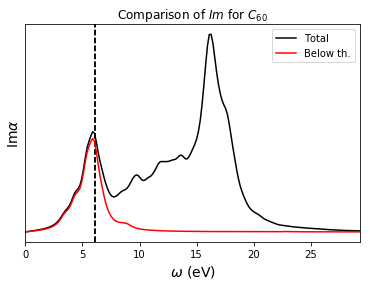

In [38]:
pt=ex.plot_alpha(c='black',label='Total')
pt=ex.plot_alpha(group='bt',c='red',label='Below th.')
pt.legend(loc='best')
pt.title('Comparison of $Im \alpha(\omega)$ for $C_{60}$')
pt.show()


# Aflatoxins
We now have a look at a molecule with no particular symmetry, the Aflaxotin, in its B1 and G2 variants.
These two molecules have different number of atoms. We however include them in the same dataset as they exhibit similar LR properties.
We do not have the reference value for the static polarizability at present.

In [43]:
afla_data=read_data_directory('Aflatoxin/')

Loading data with  (58,)  occupied and  (128,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/Aflatoxin/data-GS-b1/coupling_matrix.txt "
Using pandas:
done
Shape is conformal with the number of orbitals
Casida Matrix is symmetric True
Loading data with  (58,)  occupied and  (128,)  empty states, from file " /LR-nb/POLARIZABILITY/nb_paper/Aflatoxin/data-GS-b1/transition_quantities.txt "
Using pandas:
done
Shape is conformal with the number of orbitals


In [44]:
calculate_excitations(afla_data)

Diagonalizing Coupling matrix of shape (14848, 14848)
Eigensystem solved


In [45]:
split_excitations(afla_data)

Splitting excitations for run of size 17.426 , tolerance= 0.01
Found  112 / 14848  excitations below threshold


---------------- Dynamical polarizability, imaginary and real part


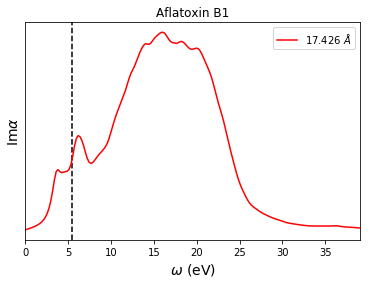

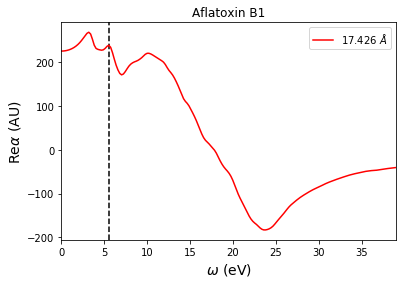

---------------- Excitation landscapes


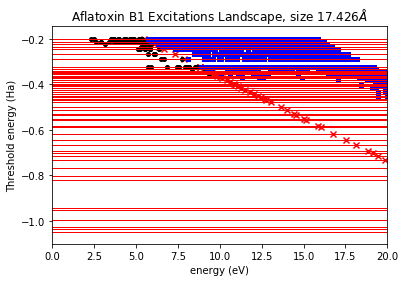

---------------- Dynamical polarizability, localized excitations only


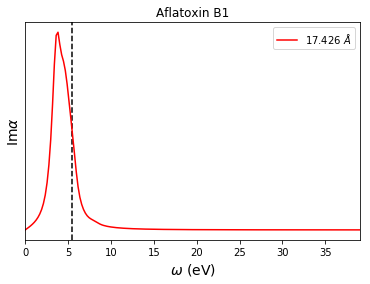

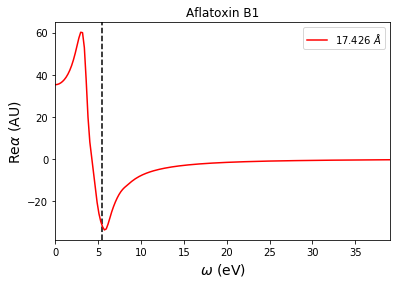

---------------- Excitations density of states, complete and splitted


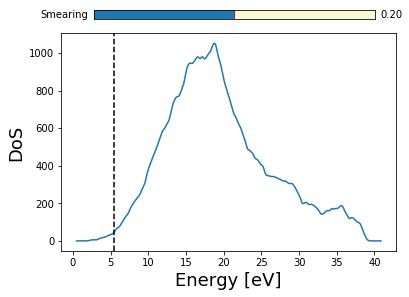

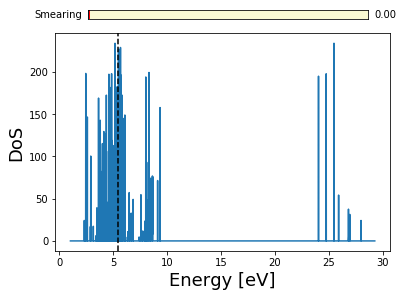

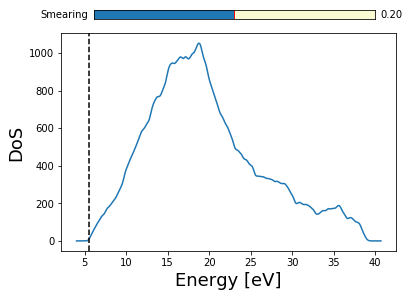

---------------- Static polarizability sum rule, "x" coordinate


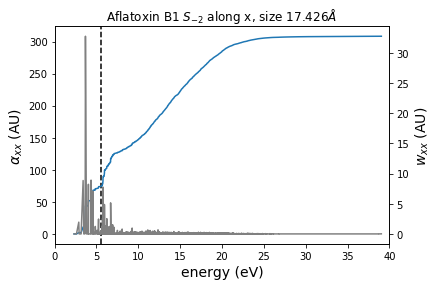

---------------- Static polarizability sum rule, "y" coordinate


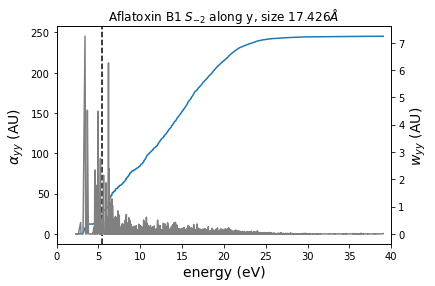

---------------- Static polarizability sum rule, "z" coordinate


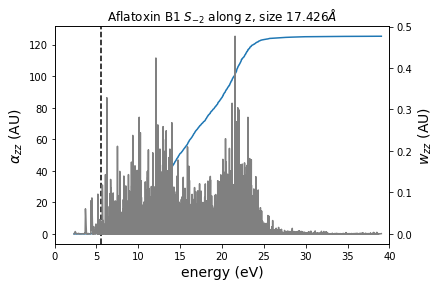

In [46]:
analyze_molecule_data('Aflatoxin B1',afla_data)

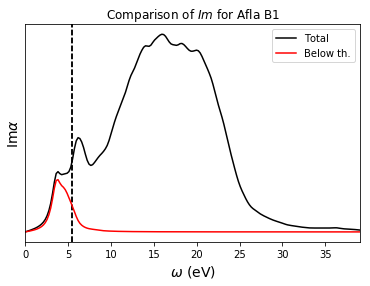

In [47]:
ex=afla_data[5.0]['excitations']
pt=ex.plot_alpha(c='black',label='Total')
pt=ex.plot_alpha(group='bt',c='red',label='Below th.')
pt.legend(loc='best')
pt.title('Comparison of $Im \alpha(\omega)$ for Afla B1')
pt.show()


# Comparison of the influence between the various excitations sectors on the polarizability tensor
We can see that the different sector of the excitations contribute differently to the polarizability tensor case.
Already, this is visible in the spectra.
By separating the various contribution to the spectra we obtain the following:

In [52]:
def compare_spectra_bt(label,ex):
    """
    Plot the spectrum by only considering the excitations 
    which have been classified below threshold
    and compare it to the reference value
    
    Args:
       label (str): label of the run
       ex (Excitations): instance of the class. Should have been already splitted.
    """
    pt=ex.plot_alpha(c='black',label='Total')
    pt=ex.plot_alpha(group='bt',c='red',label='Below th.')
    pt.legend(loc='best')
    pt.title(r'Comparison of $Im \alpha(\omega)$ for '+label)
    pt.show()

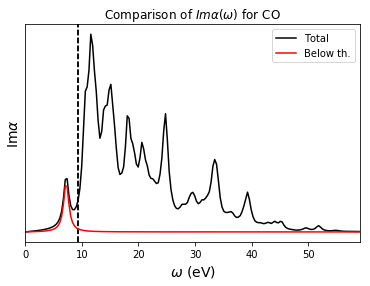

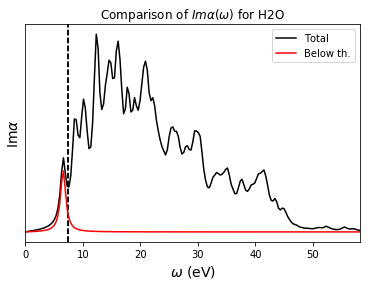

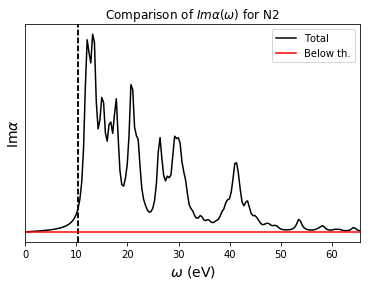

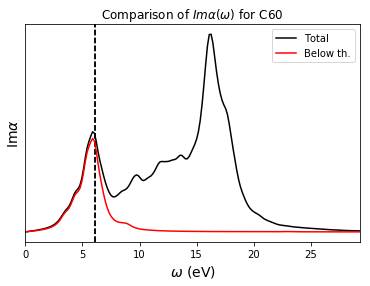

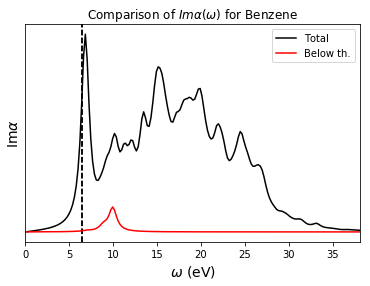

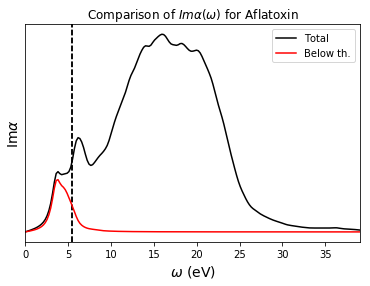

In [53]:
compare_spectra_bt('CO',CO_data[7.0]['excitations'])
compare_spectra_bt('H2O',H2O_data[7.0]['excitations'])
compare_spectra_bt('N2',N2_data[7.0]['excitations'])
compare_spectra_bt('C60',C60_data[7.0]['excitations'])
compare_spectra_bt('Benzene',C6H6_data[7.0]['excitations'])
compare_spectra_bt('Aflatoxin',afla_data[5.0]['excitations'])


Let us now verify these numbers on the statical polarizability tensor.
We will plot a table in which the reference values are compared to the values of the $S_{-2}$ rule.
We would also discriminate the terms that comes from the first threshold from the ones that come
from the entire discrete sector of the excitations

In [60]:
def decompose_Sm2(label,ref,ex):
    """
    Discriminate the various components to the Sm2 sum rule.
    
    Args:
       label (str): molecule considered
       ref (float): value of the static component of the pol.tensor
       ex (Excitations): class to be decomposed
    
    Returns :
        list: value of ref,full S-2,percent of S-2 of localized states only, percent with localized states below threshold
    """
    import numpy as np
    w_ii=np.mean(ex.alpha_prime,axis=1)
    bt=ex.excitations_below_threshold
    bfirstt=np.where(np.abs(ex.first_threshold) >= np.sqrt(ex.eigenvalues[0:len(ex.threshold_energies)]))
    tot=sum(w_ii)
    return [np.mean(ref),tot,sum(w_ii[bt])/tot,sum(w_ii[bfirstt])/tot]

In [68]:
print decompose_Sm2('N2',N2_alpha_ref,N2_data[7.0]['excitations'])
print decompose_Sm2('CO',CO_alpha_ref,CO_data[7.0]['excitations'])
print decompose_Sm2('H2O',H2O_alpha_ref,H2O_data[7.0]['excitations'])
print decompose_Sm2('Benzene',C6H6_alpha_ref,C6H6_data[7.0]['excitations'])
print decompose_Sm2('Aflatoxin',0,afla_data[5.0]['excitations'])
print decompose_Sm2('C60',C60_alpha_ref,C60_data[7.0]['excitations'])


[12.490333333333334, 12.375990113621173, 1.6135716732189588e-08, 1.6135716732189588e-08]
[15.066, 14.786064554144195, 0.08636401066058828, 0.08636401066058828]
[10.865997040000002, 685.7979855036871, 0.07570586139859076, 0.07570586139859076]
[71.11333333333333, 70.3233329294724, 0.0300051807725093, 7.298923507025084e-07]
[0.0, 226.2724224891895, 0.15873175216766203, 0.14844438023636713]
[561.594233465, 509.60134811665756, 0.3846531971608778, 0.3441501760473383]


In [73]:
(np.array([685.7979855036871, 0.07570586139859076, 0.07570586139859076])/64).tolist()

[10.71559352349511, 0.0011829040843529806, 0.0011829040843529806]

# Sketch of the workflow associated to the molecule static polarizability
We write here a tentative approach to extract the static polarizability tensor of a set of molecules.

We suppose that we have instanciated a `Logfile` class with the 
Ground-State calculation of a given molecule. From this GS we should

 * Create a set of _independent_ inputfiles with nonzero electric fields;
 * Run the calculations;
 * Inform the user if a convergence problem arise in the wavefunction optimization on each field value;
 * Post-process the `Logfile` instances of the calculated runs such as to extract the $\alpha_{ij}$ tensor;

To do that, the necessary input values that have to be provided to the workflow are:

 * The absolute value of the electric field intensity;
 * The `Logfile` instance of the GS. This will _fix_ the value of the box size to the one which has been used for the GS dipole;
 
However the above inputs might be inconsistent, for example if the electric field intensity is too large, or if the _crmult_ is not extended enough. While the box size is a strict _input_ of the workflow, we need a procedure to control that the EF intensity is within the linear-response regime.
To verify that we employ the procedure sketched in the Head-Gordon paper :

 * Calculate $\alpha$ tensor with $E=1.e-2$ and with $E=5.e-3$.
 * If the values of $\alpha$ differ more than a provdied (relative) tolerance, the calculation is performed with $E=1.e-3$.
 
This would imply that the relative tolerance is the input parameter of the entire workflow for a given `crmult` value.
 

In [ ]:
#by hypothesis we have a logfile 
logGS=L.Logfile('groundstatelog')
#we need to construct from a logfile an instance of the Inputfile class

inp=logGS.log #take the dictionary as from the logfile

from BigDFT import Inpufiles as I
inp=I.Inputfile()
inp.update(logGS.log) #the same but preserving the type of inp as Inpufile class

inp=I.Inputfile(logGS.log) #identical

inp=I.Inputile(logfile=logGS)

#instance of the dataset for the alpha
from BigDFT import Datasets as D
from BigDFt import Calculators as C
code = C. SystemCalculator()

def get_alpha_dataset(code,logGS,intensity):
    """
    Args:
        code (Runner): calculator to be used for the extraction
        logGS (Logfile): logfile instance of the reference GS
        intensity (float): electric field intensity in AU
    Returns:
       alpha (3x3 matrix): polarizability tensor
    """
    inp=I.Inputfile(logfile=logGS)
    name=logGS.log['name']
    PolTensor=D.Dataset(label='PolTensor'+name,
                        run_dir='Poltensor'+name,
                        input=inp,D0=logGS.dipole)
    for i,coord in enumerate(['x','y','z']):
        ef=np.zeros(3)
        ef[i]=intensity
        inp=I.Inputfile()
        inp.apply_electric_field(ef)
        PolTensor.append_run(id={'Ef': coord},runner=code,dict(inpx),
                             name=str(intensity)+coord)

    PolTensor.set_postprocessing_function(extract_alpha)

    return PolTensor

def get_alpha(code,logGS,tolerance):
    da1=get_alpha_dataset(code,logGS,1.e-2)
    da2=get_alpha_dataset(code,logGS,5.e-3)

    #possibly compbine the datasets
    full=D.combine_datasets(da1,da2)

    [alpha1,alpha2]=full.run()

    #check the relative difference
    if np.allclose(alpha1,alpha2,tol=norm(alpha1)*tolerance):
        return alpha2
    else:
        alpha3=get_alpha_dataset(code,logGS,1.e-3).run()
        if np.allclose(alpha3,alpha2,tol=norm(alpha2)*tolerance):
        return k

alpha=get_alpha(code,logGS,0.05)

code.set_global_option(skip=True)

alpha=get_alpha(code,logGS,0.05)


In [128]:
def extract_alpha(runs,results,run_options):
    """
    From a given set of input and logfiles extract a polarizability tensor
    
    Args:
       runs (list of dict elements): with different values of the electric fields
                assumes that the runs are in the ['x','y','z'] direction
                And the the intensity is identical.
       results (list of :py:class:`~BigDFT.Logfiles.Logfile` elements): results of the runs
       run_options (dict): dictionary of the global options of the Dataset
    """
    import numpy as np
    D0=run_options['D0']
    alpha=np.mat(np.zeros(9)).reshape(3,3)
    intensity=runs[0]['dft']['elecfield'][0]
    for i,log in enumerate(results):
        alpha[i]=(log.dipole-D0)/intensity
    return alpha

